In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from textblob import TextBlob
from textblob.sentiments import PatternAnalyzer, NaiveBayesAnalyzer

import sys
lib_dir = "../../libs/"
if lib_dir not in sys.path:
    sys.path.append(lib_dir)

import DSF_helpers

from plotly.offline import iplot,init_notebook_mode
init_notebook_mode(connected=True)

%matplotlib inline

In [2]:
tweets = pd.read_pickle("../../data/ap_tweets_classified.pkl")

In [3]:
analyzer = PatternAnalyzer()

In [4]:
def sentiment(tweet):
    p = 0
    text = tweet.text
    tb = TextBlob(tweet.text, analyzer = analyzer)
    #return tb.sentiment.classification
    output = 'neu'
    if tb.sentiment.polarity < -p:
        output = 'neg'
    elif tb.sentiment.polarity > p:
        output = 'pos'
    return output    

tweets['sentiment'] = tweets.apply(sentiment,axis=1)

In [5]:
#tweets.to_pickle("../../data/ap_tweets_classified_sentiment.pkl")

In [6]:
# Only look for USA tweets and in English
logic = (tweets.country == 'United States') & \
        (tweets.place_place_type != 'poi') & \
        (tweets.place_place_type != 'country') & \
        (tweets.lang == 'en') & \
        (tweets.place_place_type != 'neighborhood')

# Keep only USA tweets and the language is English
tweets_USA = tweets[logic]
tweets_USA['state_abrv'] = tweets_USA['place_full_name'].apply(DSF_helpers.get_state_ABRV)

/home/zenbook/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [7]:
tweets_USA = tweets_USA[tweets_USA.about.notnull()]
tweets_USA.shape

(421309, 36)

In [8]:
from random import randint
n = 5
tmp = tweets_USA.loc[:,['text', 'sentiment']]
for i in range(n):
    i = randint(0, len(tweets_USA))
    print(tmp.iat[i,0])
    print(tmp.iat[i,1])
    print()

gonna knock hell isis toughest potus ever whine media tough guy
neg

lier fbi told did
neu

motto comes talking past critics factcheckers
neg

new york life insurance fires top official wishing death activist
pos

serious shit
neg



In [9]:
pd.pivot_table(tweets_USA, index = ['about'], columns = ['sentiment'], aggfunc='size')

sentiment,neg,neu,pos
about,,,
0.0,62922,131902,84835
1.0,26534,58579,33208
2.0,5251,11812,6266


In [10]:
tweets_USA = tweets_USA[tweets_USA.sentiment != 'neu']

In [11]:
tweets_USA.shape

(219016, 36)

In [12]:
# Change the data to plot it with Seaborn

table = pd.pivot_table(tweets_USA, index = ['state_abrv'], columns = ['about', 'sentiment'], aggfunc='size').reset_index()
trump_sentiment = table.loc[:,['state_abrv', 0]].dropna()
hillary_sentiment = table.loc[:,['state_abrv', 1]].dropna()
both_sentiment = table.loc[:,['state_abrv', 2]].dropna()

trump_sentiment = trump_sentiment.assign(total = 
                                         trump_sentiment[0,'neg']+
                                         trump_sentiment[0,'pos']).sort_values('total', ascending=False)
trump_sentiment = trump_sentiment.drop('total', axis=1, level=0)
hillary_sentiment = hillary_sentiment.assign(total = 
                                         hillary_sentiment[1,'neg']+
                                         hillary_sentiment[1,'pos']).sort_values('total', ascending=False)
hillary_sentiment = hillary_sentiment.drop('total', axis=1, level=0)
both_sentiment = both_sentiment.assign(total = 
                                         both_sentiment[2,'neg']+
                                         both_sentiment[2,'pos']).sort_values('total', ascending=False)
both_sentiment = both_sentiment.drop('total', axis=1, level=0)

trump_sentiment = pd.melt(trump_sentiment, id_vars='state_abrv', value_name="count")
hillary_sentiment = pd.melt(hillary_sentiment, id_vars='state_abrv', value_name="count")
both_sentiment = pd.melt(both_sentiment, id_vars='state_abrv', value_name="count")

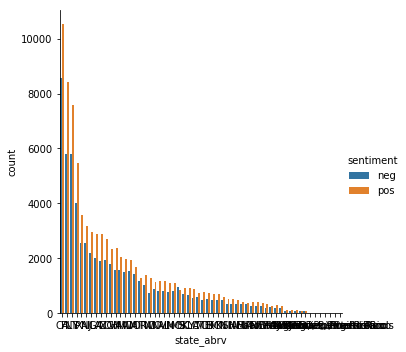

In [13]:
sns.catplot(x="state_abrv", y="count", hue="sentiment", data=trump_sentiment, kind='bar')

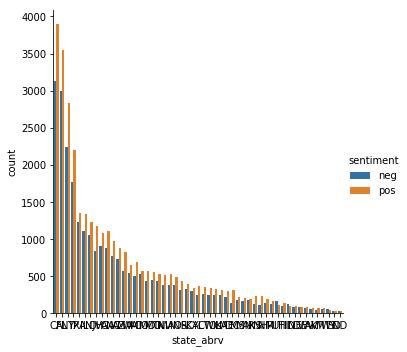

In [14]:
sns.catplot(x="state_abrv", y="count", hue="sentiment", data=hillary_sentiment, kind='bar')

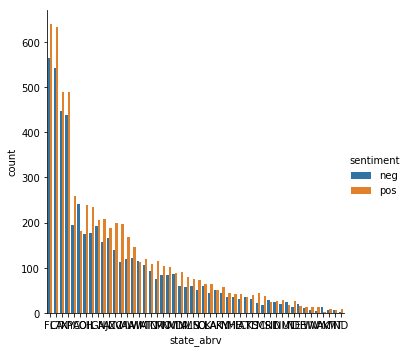

In [15]:
sns.catplot(x="state_abrv", y="count", hue="sentiment", data=both_sentiment, kind='bar')

In [16]:
def func(x):
    pos = len(x[x=='pos'])
    neg = len(x[x=='neg'])
    if neg == 0: return np.nan
    if(pos + neg < 90): return np.nan
    return pos/neg

ratio = pd.pivot_table(tweets_USA, values = ['sentiment'], index = ['state_abrv'], columns = ['about'], aggfunc=func).reset_index()
ratio.dropna(inplace=True)
ratio.drop(('sentiment', 2), axis=1, inplace=True)

In [17]:
ratio_melt = pd.melt(ratio, id_vars='state_abrv', value_name="count")

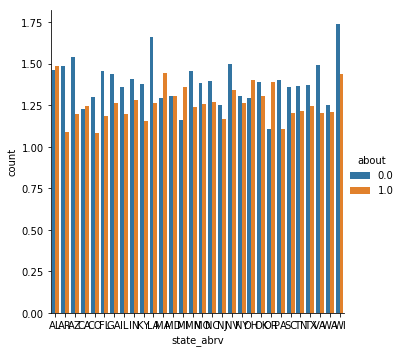

In [18]:
sns.catplot(x="state_abrv", y="count", hue="about", data=ratio_melt, kind='bar')

In [19]:
ratio['who'] = ratio.apply(lambda x: 1 if x[('sentiment', 0)] > x[('sentiment', 1)] else 0, axis=1)
#ratio['who'] = ratio.apply(lambda x: x[('sentiment', 0)] - x[('sentiment', 1)], axis=1)
#ratio['who'] = ratio.apply(lambda x: x[('sentiment', 0)], axis=1)
#ratio['who'] = ratio.apply(lambda x: x[('sentiment', 1)], axis=1)

In [20]:
ratio_map = ratio[['state_abrv', 'who']]
ratio_map.columns = ratio_map.columns.droplevel(level=1)

In [21]:
scl = [[0, '#439FE0'],[0.5,'#FFFFFF'], [1, '#FF6B7B']]
#scl = [[0,'#FFFFFF'], [1, '#FF6B7B']]
#scl = [[0,'#FFFFFF'],[1, '#439FE0']]

data = [ dict(
        type='choropleth',
        colorscale=scl,
        autocolorscale = False,
        locations = ratio_map['state_abrv'],
        z = ratio_map['who'],
        locationmode = 'USA-states',
        #text = ratio_map['state_abrv'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "ratio Trump - ratio Hillary (rounded)")
        ) ]

layout = dict(
        title = 'How positively they talk about one against the other',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict( data=data, layout=layout )
iplot( fig, filename='d3-cloropleth-map' )